In [2]:
# Importing libraries

import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# Initital configurations
SEED = 1234

def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

# Set seeds for reproducibility
set_seeds(seed=SEED)

# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")

print(device)

cpu


In [3]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 999.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [9]:
# Setting up kaggle credentials
# ! Please upload kaggle.json file before running this script

!pip install -q kaggle  # installing the kaggle package
!mkdir -p ~/.kaggle     # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/  # move the key to the folder
!chmod 600 ~/.kaggle/kaggle.json  # change the permissions of the file.

In [10]:
# Downloading dataset
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

# unzipping and removing zip file
!unzip tuberculosis-tb-chest-xray-dataset.zip
!rm -rf tuberculosis-tb-chest-xray-dataset.zip

 99% 659M/663M [00:17<00:00, 44.2MB/s]
100% 663M/663M [00:18<00:00, 38.5MB/s]
Archive:  tuberculosis-tb-chest-xray-dataset.zip
  inflating: TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1006.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1007.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1008.png

In [13]:
# Preparing dataset folder and moving the files to it.

!mkdir datasets
!cp -r TB_Chest_Radiography_Database/Normal datasets/normal
!cp -r TB_Chest_Radiography_Database/Tuberculosis datasets/tuberculosis
!cp -r TB_Chest_Radiography_Database/Normal.metadata.xlsx datasets/normal.xlsx
!cp -r TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx datasets/tuberculosis.xlsx

!rm -rf TB_Chest_Radiography_Database

mkdir: cannot create directory ‘datasets’: File exists
cp: cannot stat 'TB_Chest_Radiography_Database/Normal': No such file or directory
cp: cannot stat 'TB_Chest_Radiography_Database/Tuberculosis': No such file or directory
cp: cannot stat 'TB_Chest_Radiography_Database/Normal.metadata.xlsx': No such file or directory
cp: cannot stat 'TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx': No such file or directory


In [14]:
# Checking excel sheets  and datasets
normal_df = pd.read_excel('datasets/normal.xlsx')
tuberculosis_df = pd.read_excel('datasets/tuberculosis.xlsx')

print("-------------------Dataset------------------")
print("Total Normal CXR Images: ",len(normal_df))
print("Total Tuberculosis CXR Images: ",len(tuberculosis_df))

-------------------Dataset------------------
Total Normal CXR Images:  3500
Total Tuberculosis CXR Images:  700


In [15]:
# Splitting the datasets
"""
Here, we have logically divided the datasets into train, valid and test set in 70:15:15 ratio.
And also we have shuffled the dataset, so that both of the categories images gets mixed up.
"""
import glob
normal = glob.glob("datasets/normal/*")
tb = glob.glob("datasets/tuberculosis/*")

# Splitting in 70:15:15 ratio
train_path = normal[:2450] + tb[:490]
val_path = normal[2450:2975] + tb[490:595]
test_path = normal[2975:] + tb[595:]

# shuffling
random.shuffle(train_path)
random.shuffle(val_path)
random.shuffle(test_path)

print("-------------------Dataset------------------")
print("Total train CXR Images: ",len(train_path))
print("Total val CXR Images: ",len(val_path))
print("Total test CXR Images: ",len(test_path))

-------------------Dataset------------------
Total train CXR Images:  2940
Total val CXR Images:  630
Total test CXR Images:  630


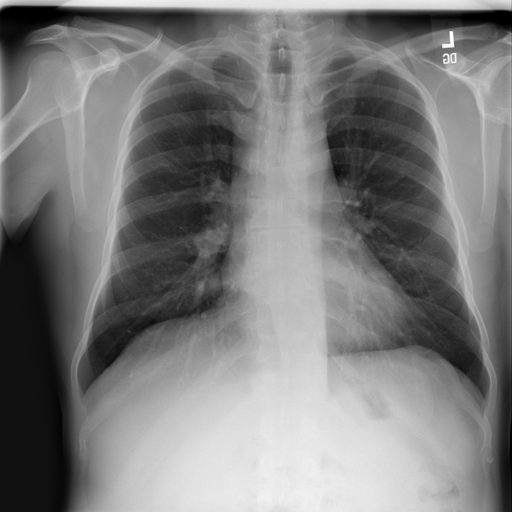

In [16]:
Image.open(train_path[0])

In [17]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.Resize(256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'others': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [18]:
class TB_CXR_Dataset(Dataset):
    def __init__(self, images, transform=None):
        self.img_paths = images
        self.img_labels = [0 if "normal" in img else 1 for img in self.img_paths]
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # get the image path and label for the specified index
        img_path = self.img_paths[idx]
        label = self.img_labels[idx]

        # load the image from the path
        image = Image.open(img_path)
        image = image.convert("RGB")

        # apply transform
        if self.transform:
            image = self.transform(image)

        # return the image and label as a tuple
        return image, label

# Dataset for train, valid and test
train_data = TB_CXR_Dataset(train_path, transform = data_transforms["train"])
valid_data = TB_CXR_Dataset(val_path, transform = data_transforms["others"])
test_data = TB_CXR_Dataset(test_path, transform = data_transforms["others"])

# Dataloader for train, valid and test
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

Data Visualization

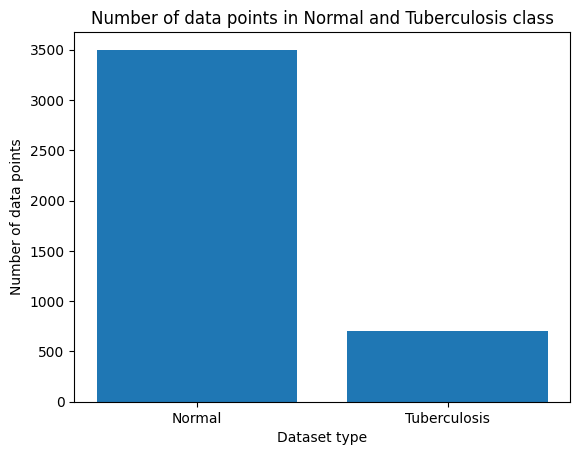

In [19]:
import matplotlib.pyplot as plt
normal_size = len(normal_df)
Tuberculosis_size = len(tuberculosis_df)
sizes = [normal_size, Tuberculosis_size]

plt.bar(['Normal', 'Tuberculosis'], sizes)

plt.xlabel('Dataset type')
plt.ylabel('Number of data points')
plt.title('Number of data points in Normal and Tuberculosis class')

plt.show()

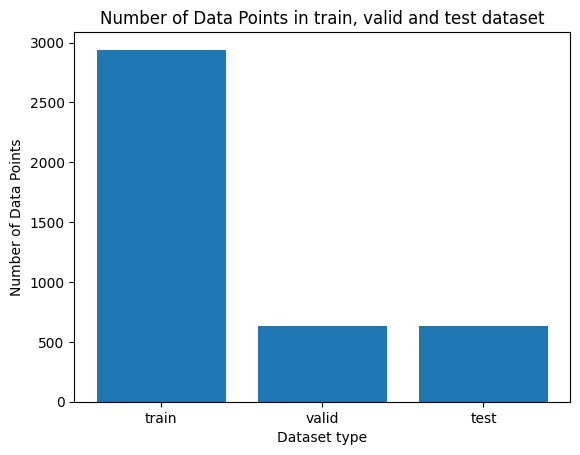

In [20]:
# Get the number of data points in each dataset
train_size = len(train_data)
valid_size = len(valid_data)
test_size = len(test_data)

# Create a list of the sizes of each dataset
sizes = [train_size, valid_size, test_size]

# Create a bar plot with the sizes of the datasets
plt.bar(['train', 'valid', 'test'], sizes)

# Add labels and title to the plot
plt.xlabel('Dataset type')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points in train, valid and test dataset')

# Show the plot
plt.show()

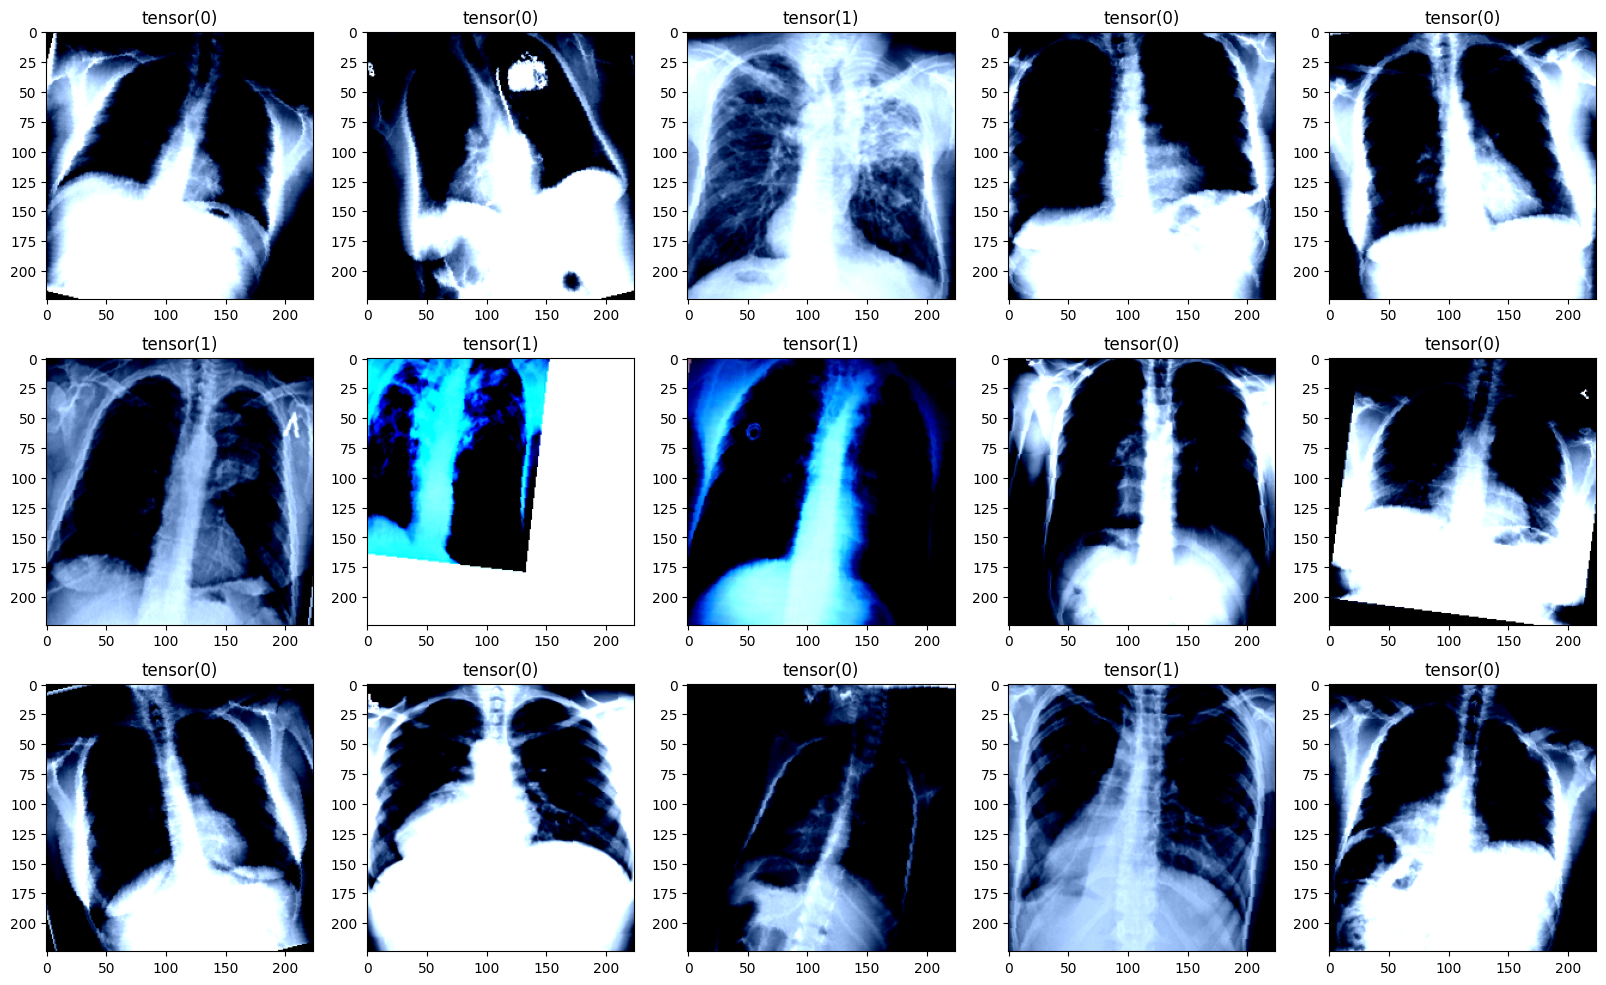

In [21]:
# Load your data using a PyTorch dataloader
data, labels = next(iter(train_dataloader))

# Create a figure with a grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=5,figsize=(20, 12))

# Plot the images in the subplots
for i, ax in enumerate(axs.flat):
    # Get the image and label for the current subplot
    image, label = data[i], labels[i]

    # Convert the image to a numpy array and plot it
    img = image.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # img = std * img + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)

    # Set the title of the subplot to the label
    ax.set_title(label)

# Show the plot
plt.show()

In [22]:
from torchvision.models import densenet121,DenseNet121_Weights, DenseNet

#model architecture
class CXR_DenseNetModel(nn.Module):
  """DenseNet121 pretrained model definition."""
  def __init__(self, num_classes):
      super(CXR_DenseNetModel, self).__init__()

      self.model = torchvision.models.densenet121(pretrained=True)

      # Freeze the model's parameters
      for param in self.model.parameters():
          param.requires_grad = False

      # Replace the last linear layer of the model
      in_features = self.model.classifier.in_features
      self.model.classifier = nn.Sequential(
          nn.Linear(in_features, in_features // 2),
          nn.Dropout(0.5),
          nn.Linear(in_features // 2, in_features // 4),
          # nn.Dropout(0.5),
          nn.Linear(in_features // 4, in_features // 8),
          nn.Dropout(0.25),
          nn.Linear(in_features // 8, num_classes),
      )

  def forward(self, x):
      return self.model(x)

model = CXR_DenseNetModel(num_classes=2)


# set device
model = model.to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 114MB/s]


CXR_DenseNetModel(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [23]:
# calculating weights for each classes

def class_weight(x,total):
  return 1 - (x/total)

total = 2450 + 490
class_weights = torch.tensor([class_weight(2450,total),class_weight(490,total)])

In [24]:
# Define the Binary CrossEntropy with Logits loss function and Adam optimizer
loss_fn = nn.BCEWithLogitsLoss(weight = class_weights.to(device))
optimizer = optim.Adam(model.parameters(),lr=0.001)

# Decay LR by a factor of 0.1 every 3 epochs
# scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [27]:
from tqdm import tqdm
import torch.nn.functional as F

train_losses = []
valid_losses = []
train_acc = []
valid_acc = []

# Define a function for the training loop
def train(model, loss_fn, optimizer, num_epochs):

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        # Training
        model.train()
        train_size = 0
        train_loss = 0.0
        correct_train = 0

        for images, labels in tqdm(train_dataloader, desc="Training Batches", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, F.one_hot(labels, 2).float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            train_size += labels.size(0)

        train_losses.append(train_loss / train_size)
        train_acc.append(correct_train / train_size)

        # Validation
        model.eval()
        valid_size = 0
        valid_loss = 0.0
        correct_valid = 0

        with torch.no_grad():
            for images, labels in tqdm(valid_dataloader, desc="Validation Batches", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, F.one_hot(labels, 2).float())

                valid_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_valid += (predicted == labels).sum().item()
                valid_size += labels.size(0)

        valid_losses.append(valid_loss / valid_size)
        valid_acc.append(correct_valid / valid_size)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_acc[-1]:.4f}")

# Train the model
train(model, loss_fn, optimizer, num_epochs=15)


Training Batches: 100%|██████████| 92/92 [18:20<00:00, 11.30s/it]
                                                                 
Epochs:   7%|▋         | 1/15 [21:37<5:02:47, 1297.69s/it]

Epoch [1/15], Train Loss: 0.0740, Train Acc: 0.9469, Valid Loss: 0.0349, Valid Acc: 0.9778



Training Batches: 100%|██████████| 92/92 [17:57<00:00, 11.35s/it]
                                                                 
Epochs:  13%|█▎        | 2/15 [43:02<4:39:27, 1289.84s/it]

Epoch [2/15], Train Loss: 0.0619, Train Acc: 0.9568, Valid Loss: 0.0387, Valid Acc: 0.9841



Training Batches: 100%|██████████| 92/92 [17:49<00:00, 11.00s/it]
                                                                 
Epochs:  20%|██        | 3/15 [1:04:02<4:15:19, 1276.62s/it]

Epoch [3/15], Train Loss: 0.0628, Train Acc: 0.9619, Valid Loss: 0.0240, Valid Acc: 0.9873



Training Batches: 100%|██████████| 92/92 [17:44<00:00, 10.94s/it]
                                                                 
Epochs:  27%|██▋       | 4/15 [1:24:55<3:52:19, 1267.22s/it]

Epoch [4/15], Train Loss: 0.0578, Train Acc: 0.9602, Valid Loss: 0.0582, Valid Acc: 0.9603



Training Batches: 100%|██████████| 92/92 [17:47<00:00, 11.10s/it]
                                                                 
Epochs:  33%|███▎      | 5/15 [1:45:53<3:30:36, 1263.63s/it]

Epoch [5/15], Train Loss: 0.0529, Train Acc: 0.9643, Valid Loss: 0.0644, Valid Acc: 0.9571



Training Batches: 100%|██████████| 92/92 [18:01<00:00, 10.68s/it]
                                                                 
Epochs:  40%|████      | 6/15 [2:07:04<3:09:55, 1266.17s/it]

Epoch [6/15], Train Loss: 0.0449, Train Acc: 0.9684, Valid Loss: 0.0261, Valid Acc: 0.9825



Training Batches: 100%|██████████| 92/92 [17:50<00:00, 10.81s/it]
                                                                 
Epochs:  47%|████▋     | 7/15 [2:28:06<2:48:39, 1264.95s/it]

Epoch [7/15], Train Loss: 0.0520, Train Acc: 0.9622, Valid Loss: 0.0300, Valid Acc: 0.9857



Training Batches: 100%|██████████| 92/92 [17:48<00:00, 10.83s/it]
                                                                 
Epochs:  53%|█████▎    | 8/15 [2:49:04<2:27:20, 1262.87s/it]

Epoch [8/15], Train Loss: 0.0429, Train Acc: 0.9690, Valid Loss: 0.0300, Valid Acc: 0.9762



Training Batches: 100%|██████████| 92/92 [17:46<00:00, 11.03s/it]
                                                                 
Epochs:  60%|██████    | 9/15 [3:10:02<2:06:07, 1261.30s/it]

Epoch [9/15], Train Loss: 0.0343, Train Acc: 0.9724, Valid Loss: 0.0323, Valid Acc: 0.9810



Training Batches: 100%|██████████| 92/92 [17:54<00:00, 11.18s/it]
                                                                 
Epochs:  67%|██████▋   | 10/15 [3:31:09<1:45:14, 1262.87s/it]

Epoch [10/15], Train Loss: 0.0378, Train Acc: 0.9731, Valid Loss: 0.0342, Valid Acc: 0.9746



Training Batches: 100%|██████████| 92/92 [18:00<00:00, 11.12s/it]
                                                                 
Epochs:  73%|███████▎  | 11/15 [3:52:25<1:24:28, 1267.01s/it]

Epoch [11/15], Train Loss: 0.0495, Train Acc: 0.9660, Valid Loss: 0.0592, Valid Acc: 0.9587



Training Batches: 100%|██████████| 92/92 [17:57<00:00, 10.93s/it]
                                                                 
Epochs:  80%|████████  | 12/15 [4:13:38<1:03:26, 1268.69s/it]

Epoch [12/15], Train Loss: 0.0445, Train Acc: 0.9684, Valid Loss: 0.0337, Valid Acc: 0.9857



Training Batches: 100%|██████████| 92/92 [17:52<00:00, 11.36s/it]
                                                                 
Epochs:  87%|████████▋ | 13/15 [4:34:43<42:15, 1267.61s/it]  

Epoch [13/15], Train Loss: 0.0431, Train Acc: 0.9704, Valid Loss: 0.0312, Valid Acc: 0.9730



Training Batches: 100%|██████████| 92/92 [17:55<00:00, 11.10s/it]
                                                                 
Epochs:  93%|█████████▎| 14/15 [4:55:48<21:06, 1266.88s/it]

Epoch [14/15], Train Loss: 0.0386, Train Acc: 0.9755, Valid Loss: 0.0418, Valid Acc: 0.9667



Training Batches: 100%|██████████| 92/92 [17:46<00:00, 11.25s/it]
                                                                 
Epochs: 100%|██████████| 15/15 [5:16:46<00:00, 1267.12s/it]

Epoch [15/15], Train Loss: 0.0333, Train Acc: 0.9769, Valid Loss: 0.0255, Valid Acc: 0.9873


Evaluation

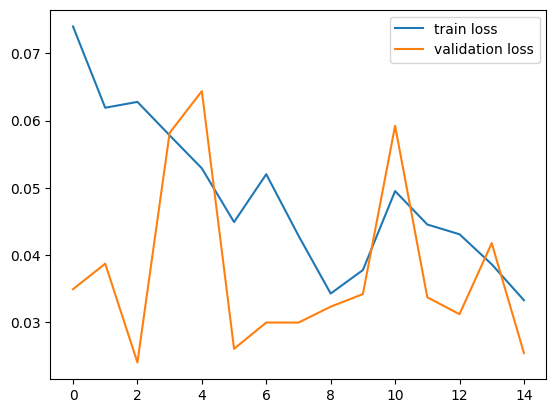

In [28]:
# plot train and test losses
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='validation loss')
plt.legend()
plt.show()